## Init

In [1]:
%matplotlib inline
import sys
import os
import pandas as pd
import math
from time import sleep

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format="[%(name)s:%(levelname)-8s] -> %(message)s")
logger = logging.getLogger()

In [3]:
pvpath = r"C:\UserData\PycharmProjects\pycat\trunk"
if os.path.exists(pvpath):
    sys.path.insert(0, pvpath)
import pycat

In [4]:
from instruments.thermal.tsr2252 import tsr2252

In [5]:
thermo = tsr2252(logger=logger)

In [6]:
thermo._statecache #before the initialization

{'mode': <MODE.AIR_CTRL: 0>,
 'setpoint': 0.0,
 'window': 0.0,
 'ramp_rate': 0.0,
 'flow_rate': 0.0,
 'flow_state': False,
 'compressor_state': False,
 'compressor_timer': 0.0,
 'head_pos': <HEAD_POS.UP: 0>,
 'head_lock': False,
 'sensor': <SENSOR.NONE: 0>}

In [7]:
thermo.Initialize("GPIB0::4::INSTR", 1, 1,"")   #gpib
#thermo.Initialize("ASRL5::INSTR", 1, "")      #usb
#thermo.Initialize("ASRL8::INSTR", 1, "")       #serial
#thermo.Initialize("TCPIP0::192.168.0.63::3456::SOCKET", 1, 1, "simulate=True")
#thermo.Initialize("TCPIP0::192.168.0.63::3456::SOCKET", 1, 1, "")

[root:INFO    ] -> Successfully connected to thermostream TSR, 2252,S/N 180006764, Rev V15 Ver 02.2019 @ GPIB0::4::INSTR


In [8]:
thermo._statecache #statecache after the initialization with the actual state of the machine

{'mode': <MODE.AIR_CTRL: 0>,
 'setpoint': 28.0,
 'window': 2.0,
 'ramp_rate': 2.0,
 'flow_rate': 0.0,
 'flow_state': False,
 'compressor_state': True,
 'compressor_timer': 0.0,
 'head_pos': <HEAD_POS.UP: 0>,
 'head_lock': False,
 'sensor': <SENSOR.NONE: 0>}

In [9]:
logger.info(thermo)

[root:INFO    ] -> Thermostream Limits:
    TEMP_HIGH = 225.0   # °C
    TEMP_LOW = -80.0    # °C
    FLOW_HIGH = 8     # unit: l/s -> 18 scfm
    FLOW_LOW = 2     # unit: l/s -> 5 scfm
    WINDOW_HIGH = 9.9   # unit: °C
    WINDOW_LOW = 0.1    # unit: °C
    RATE_HIGH = 9999    # °C/minute
    RATE_LOW = 0        # °C/minute



## Identity Feature

In [10]:
logger.info("IDN:     " + thermo.Identity.Identifier)
logger.info("FW REV:  " + thermo.Identity.InstrumentFirmwareRevision)
logger.info("DRV REV: " + thermo.Identity.Revision)

[root:INFO    ] -> IDN:     TSR, 2252,S/N 180006764, Rev V15 Ver 02.2019
[root:INFO    ] -> FW REV:  Rev V15 Ver 02.2019
[root:INFO    ] -> DRV REV: not available


## Temperature Logger

In [11]:
logpath = r"C:\temp\templog.csv"
thermo.Templogger.config(logpath, 0.1)

In [12]:
thermo.Templogger.start()
sleep(1)
thermo.Templogger.pause()
sleep(0.5)
thermo.Templogger.start()
sleep(1)
thermo.Templogger.stop()

In [13]:
thermo.Templogger.as_dataframe()

,AirTemp,DutTemp
Date,,
2019-03-07 15:50:30.597459,26.0,26.0


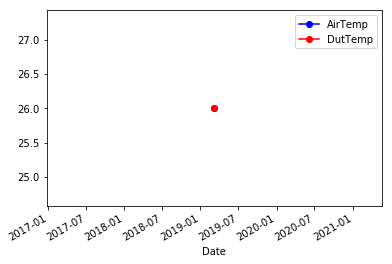

In [14]:
df = thermo.Templogger.as_dataframe()
df.plot(style=dict(AirTemp="bo-", DutTemp="ro-"))

## Properties

In [15]:
# MODE
    
thermo.parameter.Mode = thermo.Enums.MODE.DUT_CTRL
mode2 = thermo.parameter.Mode
logger.info(mode2)
assert mode2 == thermo.Enums.MODE.DUT_CTRL

thermo.parameter.Mode = thermo.Enums.MODE.AIR_CTRL
mode1 = thermo.parameter.Mode
logger.info(mode1)
assert mode1 == thermo.Enums.MODE.AIR_CTRL

[root:INFO    ] -> MODE.DUT_CTRL
[root:INFO    ] -> MODE.AIR_CTRL


In [16]:
# Temperature

logger.info("Dut Temperature: %.2f" % thermo.parameter.DutTemp)
logger.info("Air Temperature: %.2f" % thermo.parameter.AirTemp)

thermo.parameter.Mode = thermo.Enums.MODE.DUT_CTRL
logger.info("Dut Temperature: %.2f" % thermo.parameter.Temp)
thermo.parameter.Mode = thermo.Enums.MODE.AIR_CTRL
logger.info("Air Temperature: %.2f" % thermo.parameter.Temp)

[root:INFO    ] -> Dut Temperature: 26.00
[root:INFO    ] -> Air Temperature: 26.00
[root:INFO    ] -> Dut Temperature: 25.40
[root:INFO    ] -> Air Temperature: 25.60


In [17]:
# Setpoint

thermo.parameter.SetPoint = 28
rb = thermo.parameter.SetPoint
logger.info(rb)
assert rb == 28

[root:INFO    ] -> 28.0


In [18]:
# Window

thermo.parameter.Window = 2
rb = thermo.parameter.Window
logger.info(rb)
assert rb == 2

[root:INFO    ] -> 2.0


In [19]:
# RampRate - Can be set only if the head is lowered

thermo.parameter.RampRate = 10
rb = thermo.parameter.RampRate
logger.info(rb)
assert rb == 10

thermo.parameter.RampRate = 9999  # As fast as possible
rb = thermo.parameter.RampRate
logger.info(rb)
assert rb == 9999

[root:INFO    ] -> 10.0
[root:INFO    ] -> 9999.0


In [20]:
# FlowRate
thermo.parameter.HeadPosition = thermo.Enums.HEAD_POS.DOWN
sleep(0.3)
thermo.parameter.FlowState = True
try:
    thermo.parameter.FlowRate = 5
    sleep(3)
except NotImplementedError as e:
    logger.info(e, exc_info=False)
else:
    rb = thermo.parameter.FlowRate
    logger.info(rb)
    assert math.ceil(rb) == 5
thermo.parameter.FlowState = False
thermo.parameter.HeadPosition = thermo.Enums.HEAD_POS.UP

[root:INFO    ] -> 5.0


In [21]:
# HeadLock

try:
    thermo.parameter.HeadLock = True
except NotImplementedError as e:
    logger.info(e, exc_info=False)
else:
    rb = thermo.parameter.HeadLock
    logger.info(rb)
    assert rb == True

    thermo.parameter.HeadLock = False
    rb = thermo.parameter.HeadLock
    logger.info(rb)
    assert rb == False

[root:INFO    ] -> True
[root:INFO    ] -> False


In [22]:
# HeadPosition

thermo.parameter.HeadPosition = thermo.Enums.HEAD_POS.UP
rb = thermo.parameter.HeadPosition
logger.info(rb)
assert rb == thermo.Enums.HEAD_POS.UP

thermo.parameter.HeadPosition = thermo.Enums.HEAD_POS.DOWN
rb = thermo.parameter.HeadPosition
logger.info(rb)
assert rb == thermo.Enums.HEAD_POS.DOWN

[root:INFO    ] -> HEAD_POS.UP
[root:INFO    ] -> HEAD_POS.DOWN


In [23]:
# FlowState

thermo.parameter.FlowState = True
rb = thermo.parameter.FlowState
logger.info(rb)
assert rb == True
thermo.parameter.FlowState = False
rb = thermo.parameter.FlowState
logger.info(rb)
assert rb == False

[root:INFO    ] -> True
[root:INFO    ] -> False


In [24]:
# CompressorState

thermo.parameter.CompressorState = True
rb = thermo.parameter.CompressorState
logger.info(rb)
assert rb == True

thermo.parameter.CompressorState = False
rb = thermo.parameter.CompressorState
logger.info(rb)
assert rb == False

thermo.parameter.CompressorState = True
rb = thermo.parameter.CompressorState
logger.info(rb)
assert rb == True

[root:INFO    ] -> True
[root:INFO    ] -> False
[root:INFO    ] -> True


In [25]:
# CompressorTimer

try:
    thermo.parameter.CompressorTimer = 15
except NotImplementedError as e:
    logger.info(e, exc_info=False)
else:
    rb = thermo.parameter.CompressorTimer
    logger.info(rb)
    assert rb == 14 or rb == 15

    thermo.parameter.CompressorTimer = 0
    rb = thermo.parameter.CompressorTimer
    logger.info(rb)
    assert rb == 0

    logger.info(thermo.parameter.CompressorTimerRemaining)

[root:INFO    ] -> Compressor timer is not supported with TSR2252.


## Wait until temperature settled

[root:INFO    ] ->   0% of wait time has passed. Cur: 23.2°C	Target: 110.0°C.
[root:INFO    ] -> Temperature is within range. Soaking for 1 minute(s)...
[root:INFO    ] ->   0% of soaktime has passed.
[root:INFO    ] ->  20% of soaktime has passed.
[root:INFO    ] ->  40% of soaktime has passed.
[root:INFO    ] ->  60% of soaktime has passed.
[root:INFO    ] ->  80% of soaktime has passed.
[root:INFO    ] -> Finished soaking. Moving on...


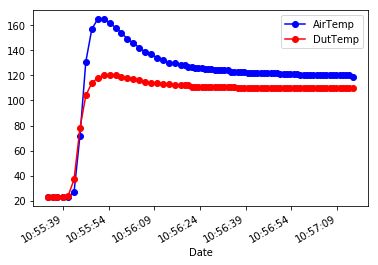

In [28]:
# Cannot be simulated
thermo.parameter.Mode = thermo.Enums.MODE.DUT_CTRL
thermo.parameter.HeadPosition = thermo.Enums.HEAD_POS.DOWN
thermo.Templogger.config(logpath, 0.1)
thermo.Templogger.start()
try:
    thermo.WaitForTemp(timeout_s=600, target=110., window_k=3, flowrate=6., soaktime_m=1, disable_exception=False)
except Exception as e:
    logger.exception(e)
finally:
    thermo.Templogger.stop()
    thermo.parameter.FlowState = False
    df = thermo.Templogger.as_dataframe()
    df.plot(style=dict(AirTemp="bo-", DutTemp="ro-"))

## Close

In [29]:
thermo.Close()

# Dev area

In [26]:
thermo.configure(thermo.Enums.MODE.AIR_CTRL, temp=60, window_k=4, flowrate=4.5) #check if flowrate is set even tho the flow state is false

In [15]:
thermo.parameter.HeadPosition = thermo.Enums.HEAD_POS.UP
#thermo.parameter.FlowState = True

In [9]:
thermo.parameter.FlowState = False

In [27]:
# FlowState TESTING

thermo.parameter.FlowState = True
sleep(0.2)
rb = thermo.parameter.FlowState
sleep(0.2)
logger.info(rb)
assert rb == True
sleep(2)
thermo.parameter.FlowState = False
sleep(0.2)
rb = thermo.parameter.FlowState
logger.info(rb)
assert rb == False

[root:INFO    ] -> True
[root:INFO    ] -> False


In [22]:
#thermo.parameter.HeadPosition = thermo.Enums.HEAD_POS.UP
#thermo.configure(thermo.Enums.MODE.AIR_CTRL, temp=40, ramprate=9999)
print(thermo.parameter.RampRate)

0.0


[root:INFO    ] ->   0% of wait time has passed. Cur: 23.3°C	Target: 60.0°C.
[root:INFO    ] ->  20% of wait time has passed. Cur: 39.8°C	Target: 60.0°C.
[root:INFO    ] -> Temperature is within range. Soaking for 0.5 minute(s)...
[root:INFO    ] ->   0% of soaktime has passed.
[root:INFO    ] ->  20% of soaktime has passed.
[root:INFO    ] ->  40% of soaktime has passed.
[root:INFO    ] ->  60% of soaktime has passed.
[root:INFO    ] ->  80% of soaktime has passed.
[root:INFO    ] -> Finished soaking. Moving on...


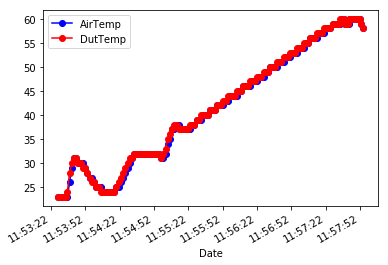

In [16]:
#thermo.parameter.Mode = thermo.Enums.MODE.DUT_CTRL
thermo.parameter.HeadPosition = thermo.Enums.HEAD_POS.DOWN
thermo.parameter.RampRate = 100
thermo.Templogger.config(logpath, 0.1)
thermo.Templogger.start()
try:
    thermo.WaitForTemp(timeout_s=600, target=60, window_k=2, flowrate=4., soaktime_m=0.5, disable_exception=False)
except Exception as e:
    logger.exception(e)
finally:
    thermo.Templogger.stop()
    thermo.parameter.FlowState = False
    df = thermo.Templogger.as_dataframe()
    df.plot(style=dict(AirTemp="bo-", DutTemp="ro-"))

In [15]:
print(thermo.parameter.HeadPosition)
thermo.parameter.RampRate = 12
thermo.parameter.RampRate

HEAD_POS.DOWN


12.0

In [14]:
thermo.parameter.CompressorState

True

In [30]:
thermo._statecache

{'mode': <MODE.AIR_CTRL: 0>,
 'setpoint': 28.0,
 'window': 2.0,
 'ramp_rate': 9999.0,
 'flow_rate': 5.0,
 'flow_state': False,
 'compressor_state': True,
 'compressor_timer': 0.0,
 'head_pos': <HEAD_POS.UP: 0>,
 'head_lock': False,
 'sensor': <SENSOR.K: 2>}

In [20]:
thermo.parameter.HeadPosition

<HEAD_POS.UP: 0>

In [21]:
thermo._write('*RST')

(4, <StatusCode.success: 0>)

In [20]:
thermo._query('TECR?')

'+0\n'

In [12]:
thermo.CheckError()

NotImplementedError: CheckError not compatible with TSR2252 thermostream